<a href="https://colab.research.google.com/github/aisaack/implementation/blob/main/Scratch_neural_net(mnist).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scratch neural net with MNIST

In [2]:
class Model:
  def __init__(self):
    self.model = []

  def add(self, X):
    self.model.append(X)

  def __call__(self, ):
    return self.model

In [52]:
import numpy as np

# Layer initialization
# Layer should be contained within a list

def layer(X: np.array, units: int, activation: str = None):
    h, w = X.shape
    if activation == 'relu':
        weight = np.random.randn(w, units).astype('float32') * np.sqrt(2 / w) # He initialization
    elif activation == 'tanh' or activation == 'softmax':
        weight = np.random.randn(w, units).astype('float32') * np.sqrt(1 / w) # Xavier initialization
    elif activation is None:
        weight = np.random.randn(w, units).astype('float32') * 0.01 # AlexNet initialization
    return weight

In [4]:
# Activattion function

def relu(X, props: str = 'fwd'):
  """X: input value
     props: decides propagation direction e.g. fwd is forward and bwd is backward
  """
  if props == 'fwd':
      return np.maximum(0, X)
  elif props == 'bwd':
      return np.greater(0, X).astype(int)
    
def tanh(X, props: str = 'fwd'):
  """X: input value
     props: decides propagation direction e.g. fwd is forward and bwd is backward
  """
  if props == 'fwd':
      return np.tanh(X)
  elif props == 'bwd':
      return 1 - np.square(np.tanh(X))

def softmax(X):
  """I didn't do backward pass because it's much efficient computing derivative when cross entropy is calculated.
  """
  score = np.exp(X - np.max(X))
  return score / np.sum(score, axis = 1, keepdims = True)

In [5]:
# Cost function

def cross_entropy(X, Y, props: str = 'fwd'):
  """X: input value
     Y: label
     props: decides propagation direction e.g. fwd is forward and bwd is backward
  """
  n = len(X)
  if props == 'fwd':
      likelyhood = -np.log(X[range(n), Y])
      return np.sum(likelyhood) / n
  elif props == 'bwd':
      X[range(n), Y] -= 1
      return X / n

def sse(X, Y, props: str = 'fwd'):
  """X: input value
     Y: label
     props: decides propagation direction e.g. fwd is forward and bwd is backward
  """
  if props == 'fwd':
      return 0.5 * np.square(X - Y)
  elif props == 'bwd':
      return X - Y

In [6]:
def forward(X, w, activation: str = None):
  d = X.dot(w)
  if activation == 'relu':
      a = relu(d)
  elif activation == 'tanh':
      a = tanh(d)
  elif activation == 'softmax':
      a = softmax(d)
  elif activation == None:
      a = d
  cache = a, d
  return a, cache

def backward(upstream, cache, w, activation: str = None):
  c1, c2 = cache
  local = upstream.dot(w.T)
  if activation == 'relu':
      upstream = local * relu(c2[1], 'bwd')
  elif activation == 'tanh':
      upstream = local * tanh(c2[1], 'bwd')
  elif activation is None:
      upstream = local
  grad = c1[0].T.dot(upstream)
  return grad, upstream

In [7]:
def momentum(weight, grad, cache: dict, lr = 1e-3, mu = 0.9):
  if len(cache) == 0:
      for layer in range(len(grad)):
          v = -lr * grad[layer]
          cache.append(v)
          weight[layer] = weight[layer] + v
  else:
      for layer in range(len(grad)):
          v = mu * cache[layer] - lr * grad[layer]
          cache[layer] = v
          weight[layer] = weight[layer] + v

In [23]:
def fit(x, y, epochs: int, activation: str, params: list, lr: float = 1e-2, mu: float = 0.9, batch_size: int = None, validation_x = None, validation_y = None):
    cache = []
    vel = []
    loss = []
    val_loss = []
    grad = [np.zeros_like(layer) for layer in params]
    if batch_size is None:
      batch_size = len(x)
    mini_batch = len(x) // batch_size
    idx = np.arange(len(x))
    if validation_x  is not None and validation_y is not None:
      n_val = len(validation_x)
      val_idx = np.arange(n_val)
      val_batch_size = n_val // mini_batch
    
    print(f'epochs: {epochs},         mini batch: {mini_batch}')
    for epoch in range(epochs):
        if validation_x is not None and validation_y is not None:
          np.random.shuffle(val_idx)
          tmp_val_x = validation_x[val_idx]
          tmp_val_y = validation_y[val_idx]
          

        np.random.shuffle(idx)
        tmp_x = x[idx]
        tmp_y = y[idx]
        if epoch % 1 == 0:
          print(f'\nepoch: {epoch+1}')

        for step in range(mini_batch):
          if validation_x is not None and validation_y is not None:
            # get_validation_data
            mini_batch_val_x = tmp_val_x[step * val_batch_size:(1+step) * val_batch_size]
            mini_batch_val_y = tmp_val_y[step * val_batch_size:(1+step) * val_batch_size]
          # get_train_data
          mini_batch_x = tmp_x[step * batch_size:(1+step) * batch_size]
          mini_batch_y = tmp_y[step * batch_size:(1+step) * batch_size]
          
          # forward pass
          X, c = forward(mini_batch_x, params[0], activation)
          cache.append(c)
          for layer in range(1, len(params)-1):
              X, c = forward(X, params[layer], activation)
              cache.append(c)
          X, c = forward(X, params[-1], 'softmax')
          cache.append(c)

          # validation
          X_val, _ = forward(mini_batch_val_x, params[0], activation)
          for layer in range(1, len(params)-1):
              X_val, _ = forward(X_val, params[layer], activation)
          X_val, _ = forward(X_val, params[-1], 'softmax')
          v_cost = cross_entropy(X_val, mini_batch_val_y, 'fwd')
          val_loss.append(v_cost)

          # loss calculation
          cost = cross_entropy(X, mini_batch_y, 'fwd')
          loss.append(cost)

          # backward pass
          upstream = cross_entropy(X, mini_batch_y, 'bwd')
          grad[-1] = cache[-2][0].T.dot(upstream)
          for layer in range(len(grad)-2, 0, -1):
              grad[layer], upstream = backward(upstream, cache[layer-1:layer+1], params[layer+1], 'relu')
          local = upstream.dot(params[1].T)
          upstream = local * relu(cache[0][1], 'bwd')
          grad[0] = mini_batch_x.T.dot(upstream)

          # SGD momentum optimizer
          momentum(params, grad, cache = vel, lr=lr, mu=0.9)
          if step % 15 == 0:
            print(f'step: {step+1}            train loss: {cost}               val loss:{v_cost}')
    return loss, val_loss

## Preparing dataset

In [12]:
import tensorflow as tf
mnist = tf.keras.datasets.mnist

In [13]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (10000, 28, 28)
(60000,) (10000,)


### Normalize

In [14]:
x_train, x_test = x_train / 255.0, x_test / 255.0

### Spliting training / validation set

In [15]:
X_train, X_val = x_train[:50000], x_train[50000:]
Y_train, Y_val = y_train[:50000], y_train[50000:]

### Image matrices to vecor

In [16]:
def flatten(X):
  n = X.shape[0]
  return X.reshape(n, -1)
X_trn = flatten(X_train)
X_val = flatten(X_val)

Creating a model object that contains weight matrices

In [44]:
model_tanh= Model()
model_tanh.add(layer(X_trn, units = 128, activation = 'tanh'))
model_tanh.add(layer(model_tanh.model[-1], units = 64, activation = 'tanh'))
model_tanh.add(layer(model_tanh.model[-1], units = 10, activation = 'softmax'))

In [46]:
train_tanh, val_tanh = fit(X_trn, Y_train, activation = 'tanh', params = model_tanh.model, validation_x = X_val, validation_y =Y_val, epochs = 10, batch_size = 256)

epochs: 10,         mini batch: 195

epoch: 1
step: 1            train loss: 2.345575364197249               val loss:2.330477505032548
step: 16            train loss: 2.1033669449588475               val loss:2.1675287617379713
step: 31            train loss: 1.8473306435409487               val loss:1.6928141169932776
step: 46            train loss: 1.5227460204895475               val loss:1.4793161229809237
step: 61            train loss: 1.2240355752142804               val loss:1.2193453299071098
step: 76            train loss: 1.006019906793484               val loss:1.0896148029615567
step: 91            train loss: 1.0316981619186263               val loss:1.0783964654370588
step: 106            train loss: 0.7954587571927462               val loss:0.7759632572511863
step: 121            train loss: 0.7992955462435682               val loss:0.7945294364456175
step: 136            train loss: 0.6976019865127933               val loss:0.6248617282140033
step: 151            trai

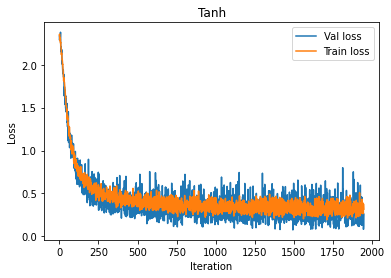

In [47]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(val_tanh)), val_tanh, label = 'Val loss')
plt.plot(np.arange(len(train_tanh)), train_tanh, label = 'Train loss')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.legend()
plt.title('Tanh')
plt.show()

In [32]:
def predict(x, activation:str, params: list):
    X, _ = forward(x, params[0], activation)
    for layer in range(1, len(params)-1):
        X, _ = forward(X, params[layer], activation)
    X, _ = forward(X, params[-1], 'softmax')
    out = np.argmax(X, axis = 1)
    return out

In [41]:
predict(flatten(x_test[30:40]), activation = 'tanh', params = model.model)

array([3, 1, 3, 0, 7, 2, 7, 1, 2, 1])

In [42]:
y_test[30:40]

array([3, 1, 3, 4, 7, 2, 7, 1, 2, 1], dtype=uint8)

In [55]:
model_relu= Model()
model_relu.add(layer(X_trn, units = 128, activation = 'relu'))
model_relu.add(layer(model_relu.model[-1], units = 64, activation = 'relu'))
model_relu.add(layer(model_relu.model[-1], units = 10, activation = 'softmax'))

In [56]:
train_relu, val_relu = fit(X_trn, Y_train, activation = 'relu', params = model_relu.model, validation_x = X_val, validation_y =Y_val, epochs = 10, batch_size = 256)

epochs: 10,         mini batch: 195

epoch: 1
step: 1            train loss: 2.4316136805337267               val loss:2.331502910448819
step: 16            train loss: 2.2879709987932704               val loss:2.2721806730762677
step: 31            train loss: 2.104811300730267               val loss:2.1657659004165706
step: 46            train loss: 1.9498114979610746               val loss:1.8677089205574942
step: 61            train loss: 1.7051623960340432               val loss:1.6824602481750457
step: 76            train loss: 1.529349363197687               val loss:1.4403679881801836
step: 91            train loss: 1.31997488965496               val loss:1.4957922756692874
step: 106            train loss: 1.1838558424458328               val loss:1.2379282969367387
step: 121            train loss: 0.975289298754499               val loss:0.8989553256854442
step: 136            train loss: 0.8954084800388787               val loss:0.9051929688277124
step: 151            train l

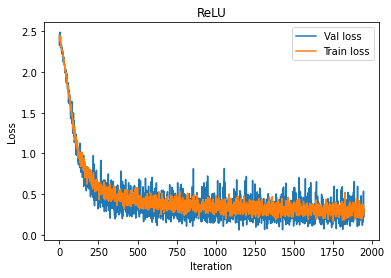

In [57]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(val_relu)), val_relu, label = 'Val loss')
plt.plot(np.arange(len(train_relu)), train_relu, label = 'Train loss')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.legend()
plt.title('ReLU')
plt.show()

In [58]:
predict(flatten(x_test[30:40]), activation = 'relu', params = model2.model)

array([3, 1, 3, 0, 7, 2, 7, 1, 2, 1])

In [59]:
y_test[30:40]

array([3, 1, 3, 4, 7, 2, 7, 1, 2, 1], dtype=uint8)

batch gradient descent는 100 epcoh으로 학습해도 loss가 2에 머물렀다. 6만개를 한 번에 때려넣어서 그런가 학습속도도 빠르지 않았다. 반면 mini batch gradient descent는 한 번에 모든 데이터를 보는 게 아닐뿐더러 mini batch를 나누면서 뒤에 남는 데이터는 누락되지만 10 epochs에도 counter part보다 10배 좋은 성능을 보여주면서 메모리 소모도 적고 학습속도도 빨랐다. 모든 iteration에서 학습데이터가 다르기때문에 일반화 성능도 좋다고 알려져있다.

더 좋은 성능을 기대하려면 
1. weight deacy 추가
2. batch norm layer 추가
3. adam optimizer 쓰기
4. dropout layer 추가

이 정도 생각할 수 있다.